In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.dates as mdates


In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, extract


In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)
# reflect the tables
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [7]:
# We can view all of the classes that automap found
print('measurement class table info')
measure = inspector.get_columns('measurement')
for x in measure:
    print(x["name"], x["type"])


print('-'*50)   
print('station class table info')


station = inspector.get_columns('station')
for y in station:
    print(y['name'], y['type'])

measurement class table info
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
--------------------------------------------------
station class table info
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

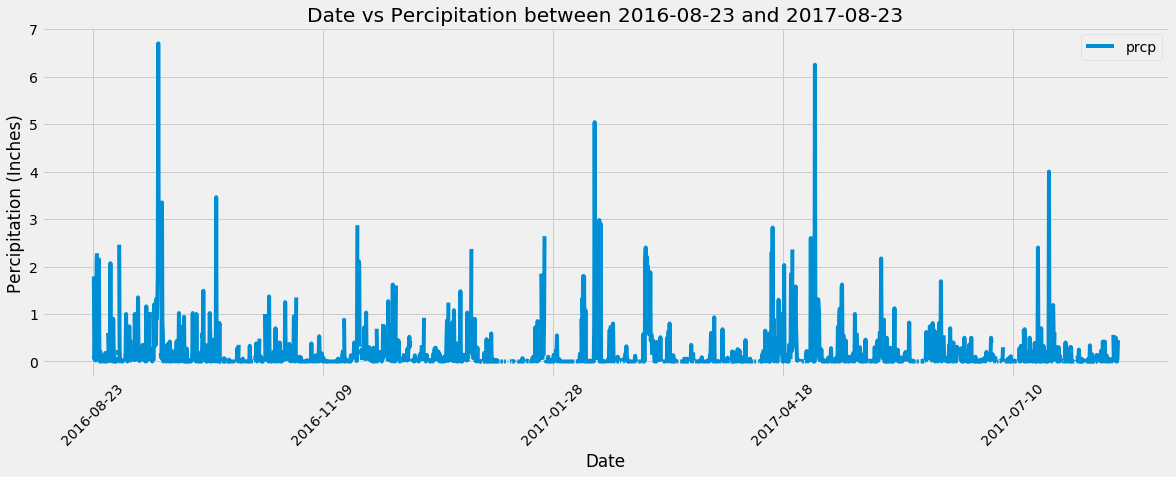

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# engine.execute('select * from measurement').fetchall()
# Calculate the date 1 year ago from the last data point in the database
xy = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
xy = xy[0]
end_date = pd.to_datetime(xy).date()
start_date = end_date - pd.DateOffset(years = 1)
start_date = pd.to_datetime(start_date).date()
# Perform a query to retrieve the data and precipitation scores
last_year_prcp = session.query(Measurement.date, Measurement.prcp).\
                filter(Measurement.date >= start_date).\
                filter(Measurement.date <= end_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
last_year_prcp_df = pd.DataFrame(last_year_prcp)

# Sort the dataframe by date
filtered_df = last_year_prcp_df.sort_values(by=['date'])

# Use Pandas Plotting with Matplotlib to plot the data
filtered_df = filtered_df.set_index(filtered_df['date'])
filtered_df=filtered_df.sort_index()
filtered_df.head()
filtered_df.plot(rot=45, figsize = (18,6))
plt.title(f'Date vs Percipitation between {start_date} and {end_date}')
plt.xlabel('Date')
plt.ylabel('Percipitation (Inches)')
plt.savefig('Images/Perciptiation_Chart.png')
plt.show()


In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
filtered_df.describe()



,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.station).group_by(Station.station).count()
print(f'There are {station_count} different weather stations')

There are 9 different weather stations


In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_usage = engine.execute('''
SELECT s.'station', COUNT(m.'id') as measurments
FROM station s, measurement m WHERE m.'station' = s.'station'
GROUP BY s.'station'
ORDER BY measurments desc''').fetchall()

Station_usage_df = pd.DataFrame(station_usage, columns=["Station", "Entries"])

Max_used_station = Station_usage_df['Station'].head(1)
Max_used_station=Max_used_station[0]
Station_usage_df

,Station,Entries
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
Station_stats = session.query(Measurement.station, func.max(Measurement.tobs), func.min(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == Max_used_station).all()
Station_stats_df = pd.DataFrame(Station_stats, columns=['Station','Max_Temp', 'Min_Temp', 'Avg_Temp'])
Station_stats_df

,Station,Max_Temp,Min_Temp,Avg_Temp
0,USC00519281,85.0,54.0,71.663781


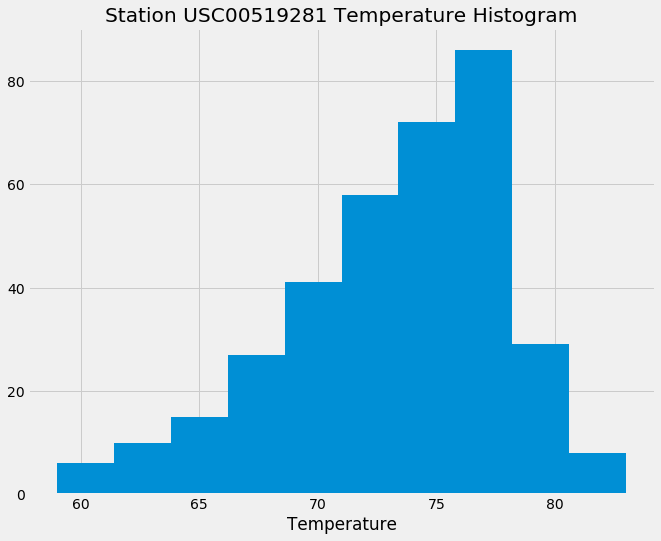

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
Temps_Max_Station = session.query(Measurement.date,Measurement.tobs).filter(Measurement.date>=start_date).filter(Measurement.date<=end_date).filter(Measurement.station == Max_used_station).all()
Temps_Max_Station_df = pd.DataFrame(Temps_Max_Station, columns=['Date', 'Temperature'])
Temps_Max_Station_df

plt.figure(figsize=(10,8))
plt.hist(Temps_Max_Station_df['Temperature'])
plt.title(f'Station {Max_used_station} Temperature Histogram')
plt.xlabel('Temperature')
plt.savefig(f'Images/Station_{Max_used_station}_Histogram.png')
plt.show()


## Bonus Challenge Assignment

# Temperature Analysis I


In [29]:
results_june = session.query(func.avg(Measurement.tobs)).filter(extract('month', Measurement.date)==6).first()
results_dec = session.query(func.avg(Measurement.tobs)).filter(extract('month', Measurement.date)==12).first()

print(f'The average temperature for June is {round(results_june[0],0)} in Hawaii')
print(f'The average temperature for December is {round(results_dec[0],0)} in Hawaii')

The average temperature for June is 75.0 in Hawaii
The average temperature for December is 71.0 in Hawaii


In [ ]:

# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))


In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
